# Import data
Import packages and prepare workspace

In [1]:
import numpy as np
import scanpy as sc
import seaborn as sns
import pandas as pd
import anndata as ad
import decoupler as dc
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80, dpi_save = 300, figsize = (5,4), transparent=True, format = 'pdf')
sc.settings.figdir = '/Volumes/G_DRIVE_SSD/Parse_WT/Analyzed_plots/sgKat7'

# Set seeds for reproducibility
# np.random.seed(123)
# sc.settings.seed = 123

In [2]:
data_path = '/Volumes/G_DRIVE_SSD/Parse_Mini/sgKat7/output/2023_10_20/combined/all-well/DGE_filtered/'

## Load h5ad file created from Parse script 
This file include the unspliced reads.  Afterward we're reading in the combined cell metadata file in the original analsyis that contains the sample information from the output of the "all-well" sample. This file is located in the `DGE_filtered` folder in the `all-well` sample folder. This combined metadata file is obtatined after running `split-pipe --mode comb` and will allow us to find the exact barcodes that correspond both anndata objects.

In [3]:
# The DGE_filtered folder contains the expression matrix, genes, and files
# NOTE: split-pipe versions older than 1.1.0 used 'DGE.mtx'
adata = sc.read_mtx(data_path + 'DGE.mtx')

# reading in gene and cell data
gene_data = pd.read_csv(data_path + 'all_genes.csv')
cell_meta = pd.read_csv(data_path + 'cell_metadata.csv')

# find genes with nan values and filter
gene_data = gene_data[gene_data.gene_name.notnull()]
notNa = gene_data.index
notNa = notNa.to_list()

# remove genes with nan values and assign gene names
adata = adata[:,notNa]
adata.var = gene_data
adata.var.set_index('gene_name', inplace=True)
adata.var.index.name = None
adata.var_names_make_unique()

# add cell meta data to anndata object
adata.obs = cell_meta
adata.obs.set_index('bc_wells', inplace=True)
adata.obs.index.name = None
adata.obs_names_make_unique()

sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)

# Returns the dimensions of the expression matrix (cells, genes)
adata.shape

/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


(1456, 19550)

In [4]:
missing_in_cell_meta = adata.obs.index.difference(cell_meta.index)

# Get the indices that are present in comb_meta but not in adata.obs
missing_in_adata_obs = cell_meta.index.difference(adata.obs.index)

# Print the mismatched indices
print("Indices missing in comb_meta:")
print(missing_in_cell_meta)
print("\nIndices missing in adata.obs:")
print(missing_in_adata_obs)

Indices missing in comb_meta:
Index([], dtype='object')

Indices missing in adata.obs:
Index([], dtype='object')


# Select samples for analysis
## Analyzing sgKat7 vs sgSafes

In [5]:
adata = adata[adata.obs['sample'].isin(["sgKat7_MT2174","sgKat7_SL768","sgKat7_MT2170", "sgSafe23_MT2162","sgSafe23_MT2242","sgSafe23_MT2252"])]
adata.obs['sample'].value_counts()

sgKat7_SL768       755
sgKat7_MT2174      236
sgSafe23_MT2252    208
sgKat7_MT2170      174
sgSafe23_MT2242     83
Name: sample, dtype: int64

# QC and filter low quality cells
following https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering-2017.html

## QC Metrics

In [6]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^Hb[^(p)]"))

/var/folders/zd/n88znlnj3gj1cs4q1qk295xr0000gn/T/ipykernel_50826/1376095374.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var_names.str.startswith("mt-")


In [7]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)
adata

AnnData object with n_obs × n_vars = 1456 × 19550
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_well', 'bc2_well', 'bc3_well', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_id', 'genome', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

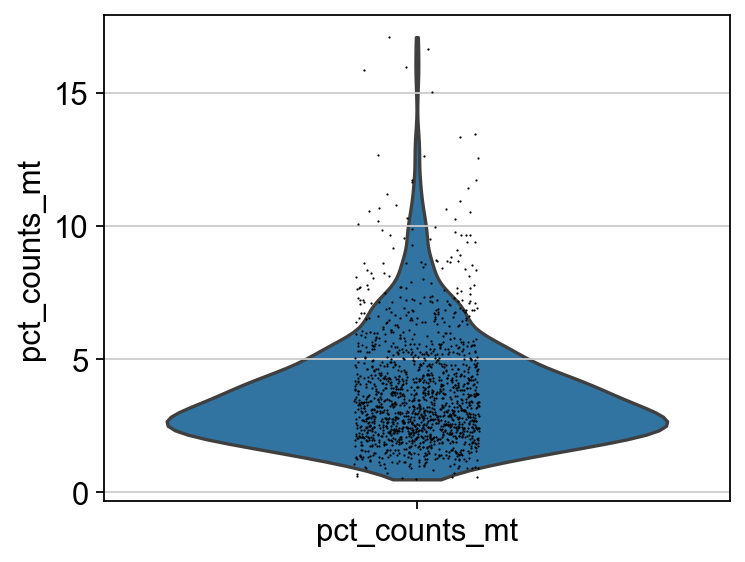

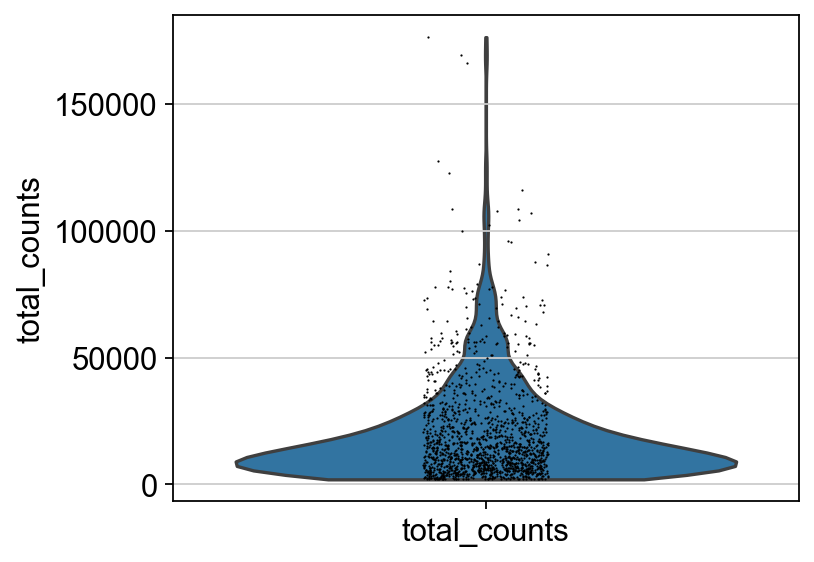

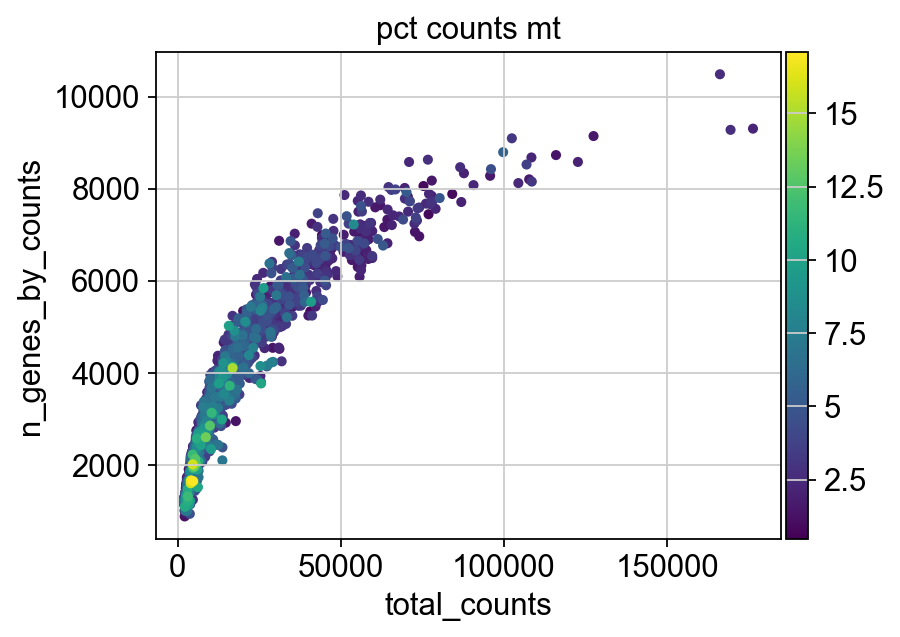

In [8]:
# sns.displot(adata.obs["total_counts"], bins=100, kde=False)
sc.pl.violin(adata, "pct_counts_mt", ylabel="pct_counts_mt")
sc.pl.violin(adata, "total_counts", ylabel="total_counts")
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

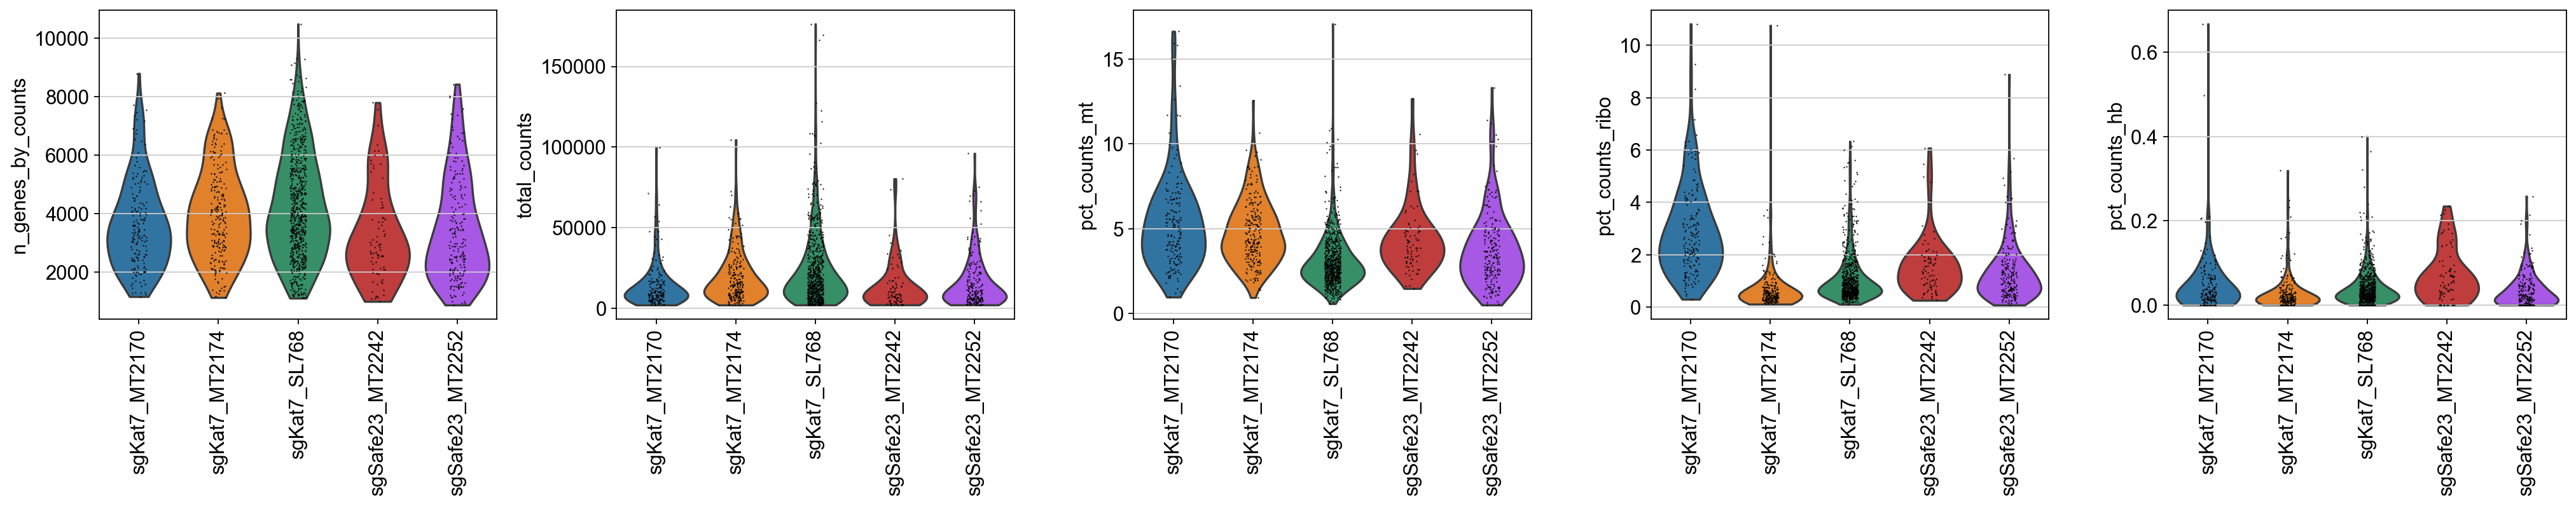

In [9]:
p4 = sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'], groupby = 'sample', rotation= 90)

## Filter

In [10]:
# Filter the data
adata = adata[adata.obs.n_genes_by_counts < 8000,:]
adata = adata[adata.obs.total_counts < 75000,:]
adata = adata[adata.obs.pct_counts_mt < 10,:]

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Number of cells after filtering of low quality cells: 1397


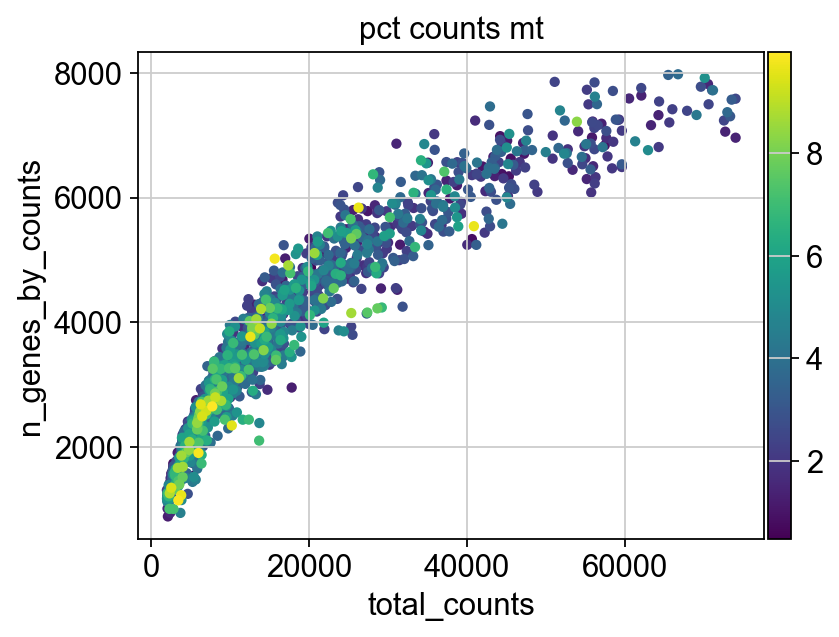

In [11]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

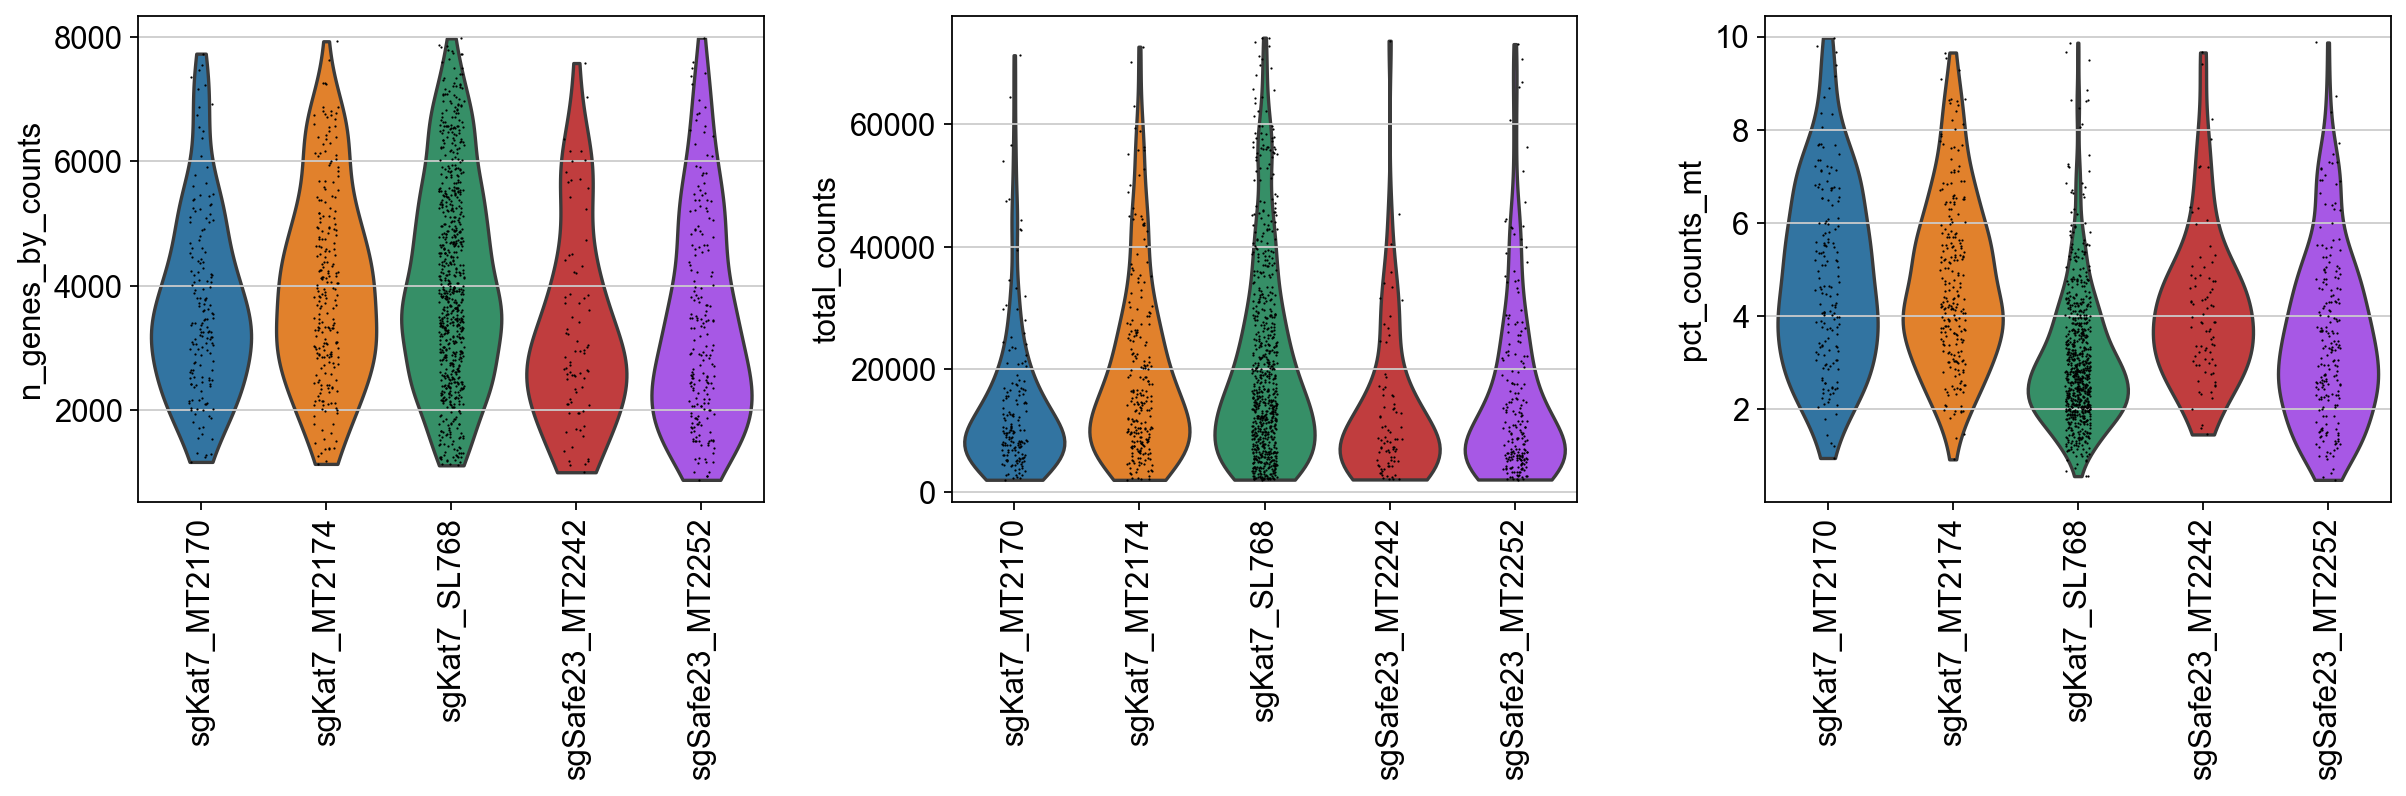

In [12]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], groupby = 'sample', rotation= 90)

## Doublet Detection
citation https://www.sciencedirect.com/science/article/pii/S2405471218304745

In [13]:
import scrublet as scr

In [14]:
scrub = scr.Scrublet(adata.X, expected_doublet_rate = 0.075)

In [15]:
adata.obs['doublet_scores'], adata.obs['predicted_doublets']  = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 2.9%
Overall doublet rate:
	Expected   = 7.5%
	Estimated  = 0.0%
Elapsed time: 1.4 seconds


/var/folders/zd/n88znlnj3gj1cs4q1qk295xr0000gn/T/ipykernel_50826/54558675.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'], adata.obs['predicted_doublets']  = scrub.scrub_doublets()


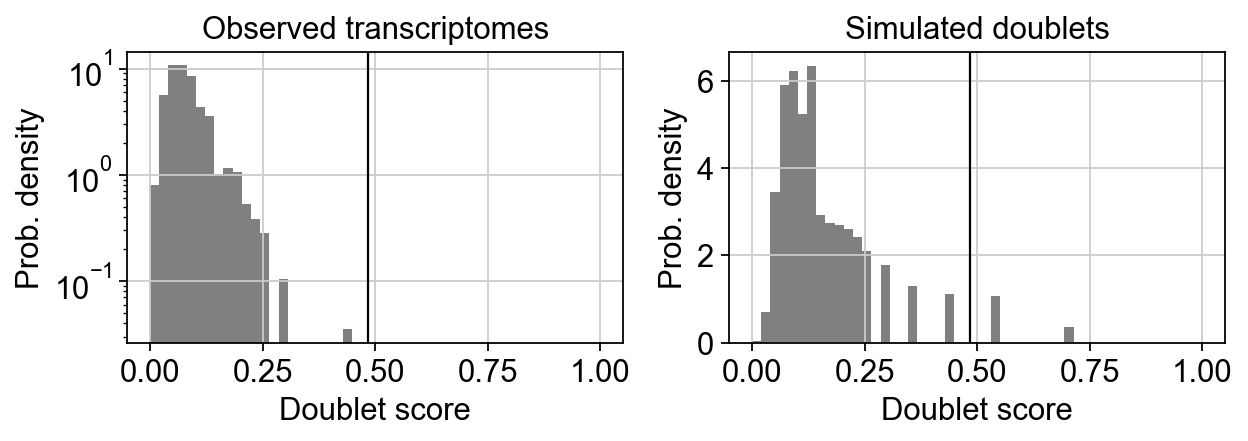

In [16]:
%matplotlib inline
p8 = scrub.plot_histogram()

In [17]:
print('Running UMAP...')
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))

# # Uncomment to run tSNE - slow
# print('Running tSNE...')
# scrub.set_embedding('tSNE', scr.get_tsne(scrub.manifold_obs_, angle=0.9))

# # Uncomment to run force layout - slow
# print('Running ForceAtlas2...')
# scrub.set_embedding('FA', scr.get_force_layout(scrub.manifold_obs_, n_neighbors=5. n_iter=1000))
    
print('Done.')

Running UMAP...


/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/p

Done.


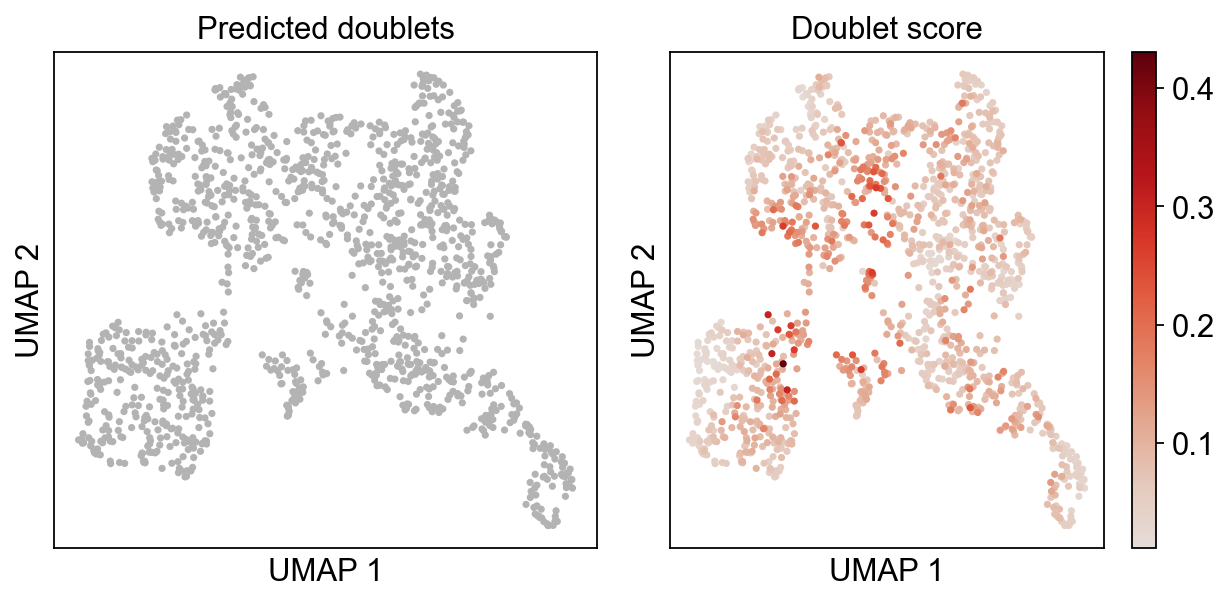

In [18]:
p9 = scrub.plot_embedding('UMAP', order_points=True);

# scrub.plot_embedding('tSNE', order_points=True);
# scrub.plot_embedding('FA', order_points=True);

In [19]:
adata.obs['predicted_doublets'].value_counts()

False    1397
Name: predicted_doublets, dtype: int64

In [20]:
# filter doublets
adata = adata[~adata.obs['predicted_doublets']]

In [21]:
adata

View of AnnData object with n_obs × n_vars = 1397 × 19550
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_well', 'bc2_well', 'bc3_well', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_scores', 'predicted_doublets'
    var: 'gene_id', 'genome', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'sample_colors'

In [22]:
adata.obs["Genotype"] = adata.obs['sample'].apply(lambda x:x.split('_')[0])

/var/folders/zd/n88znlnj3gj1cs4q1qk295xr0000gn/T/ipykernel_50826/3935425041.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Genotype"] = adata.obs['sample'].apply(lambda x:x.split('_')[0])


# Normalization
https://nbisweden.github.io/workshop-scRNAseq/labs/scanpy/scanpy_02_dimred.html

In [23]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

# store normalized counts in the raw slot, 
# we will subset adata.X for variable genes, but want to keep all genes matrix as well.
adata.raw = adata

# adata

import scipy.sparse

# Get raw counts from adata.layers or adata.raw.X
counts = adata.layers['counts']  # or counts = adata.raw.X

# Convert sparse matrix to dense if necessary
counts_array = counts.toarray() if scipy.sparse.issparse(counts) else counts

# Create DataFrame
counts_df = pd.DataFrame(
    counts_array,
    index=adata.obs_names,
    columns=adata.var_names
)

# Add metadata
counts_df['sample'] = adata.obs['sample'].values
counts_df['Genotype'] = adata.obs['Genotype'].values

counts_df

counts_df.to_csv('sgKat7_counts_df_full.csv')

# Feature Selection

Highly variable genes: 3576


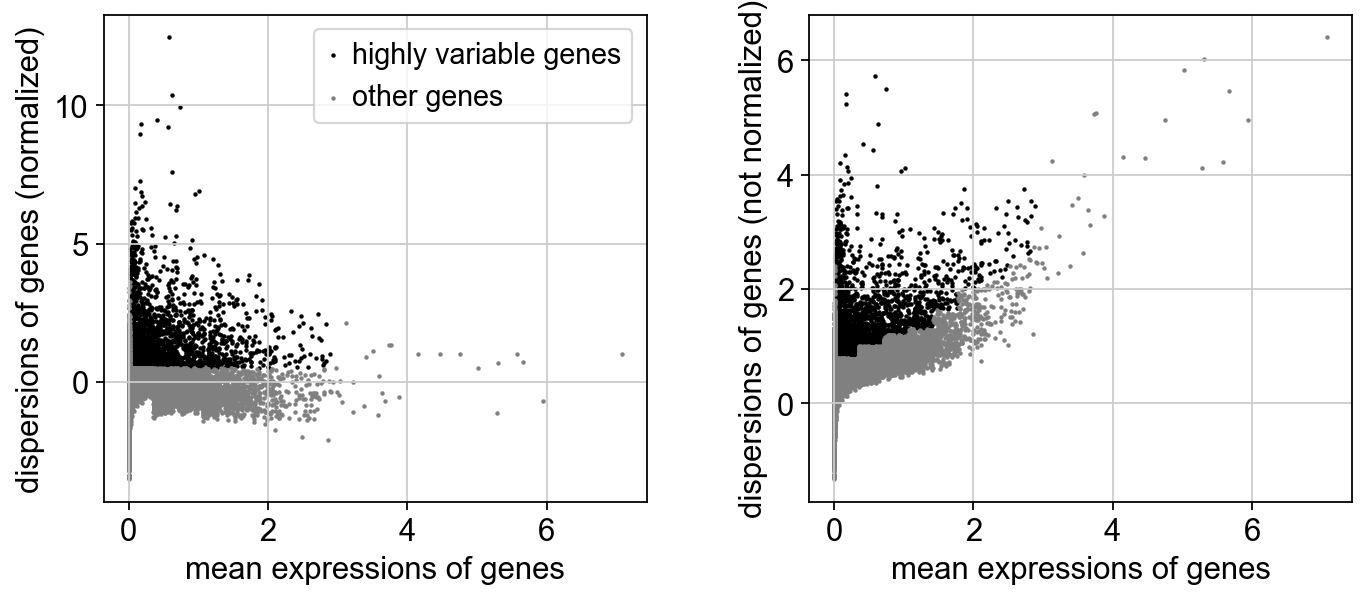

In [24]:
# compute variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print("Highly variable genes: %d"%sum(adata.var.highly_variable))

#plot variable genes
sc.pl.highly_variable_genes(adata)

# subset for variable genes in the dataset
adata = adata[:, adata.var['highly_variable']]

In [25]:
#run this line if you get the "AttributeError: swapaxes not found" 
# adata = adata.copy()

# regress out unwanted variables
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# scale data, clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


# PCA

In [26]:
sc.tl.pca(adata, svd_solver='arpack')

sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

# Clustering and UMAP

In [27]:
sc.pp.neighbors(adata, n_pcs = 50, n_neighbors = 20)

In [28]:
sc.tl.umap(adata)

/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


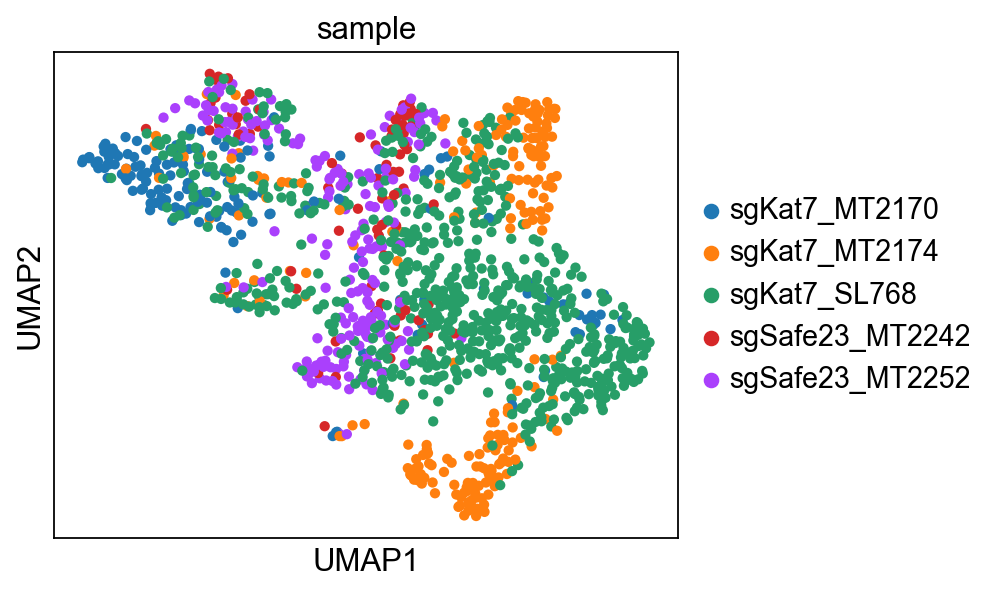

In [29]:
sc.pl.umap(adata,color="sample")

In [30]:
sc.tl.leiden(adata, resolution = 0.5, key_added = "leiden_0.5")
sc.tl.leiden(adata, resolution = 1.0, key_added = "leiden_1.0")
sc.tl.leiden(adata, resolution = 1.5, key_added = "leiden_1.5")

/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


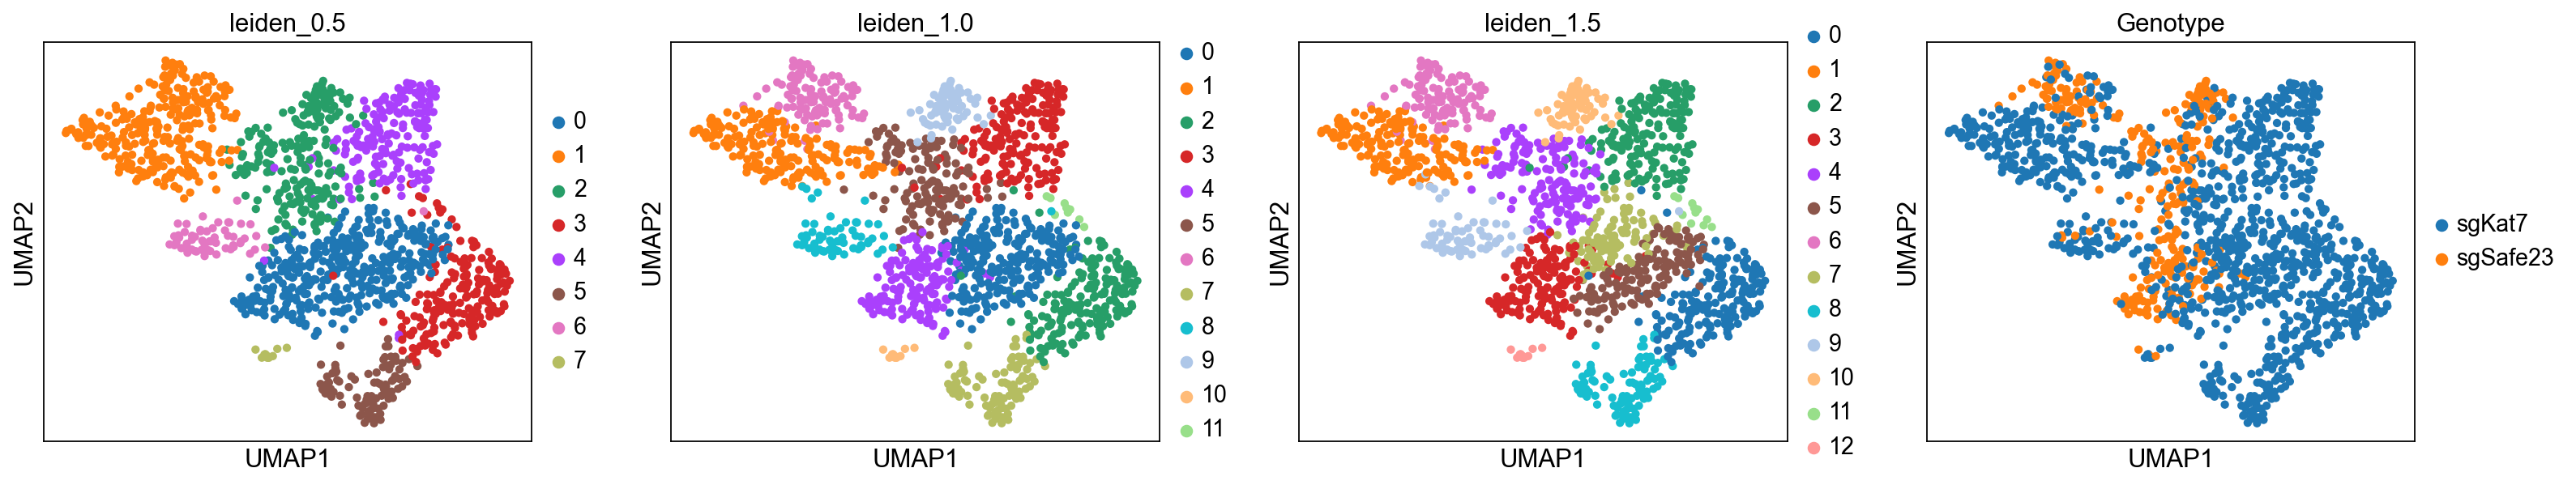

In [31]:
sc.pl.umap(adata, color=['leiden_0.5', 'leiden_1.0', 'leiden_1.5','Genotype'])

# Identify TME clusters

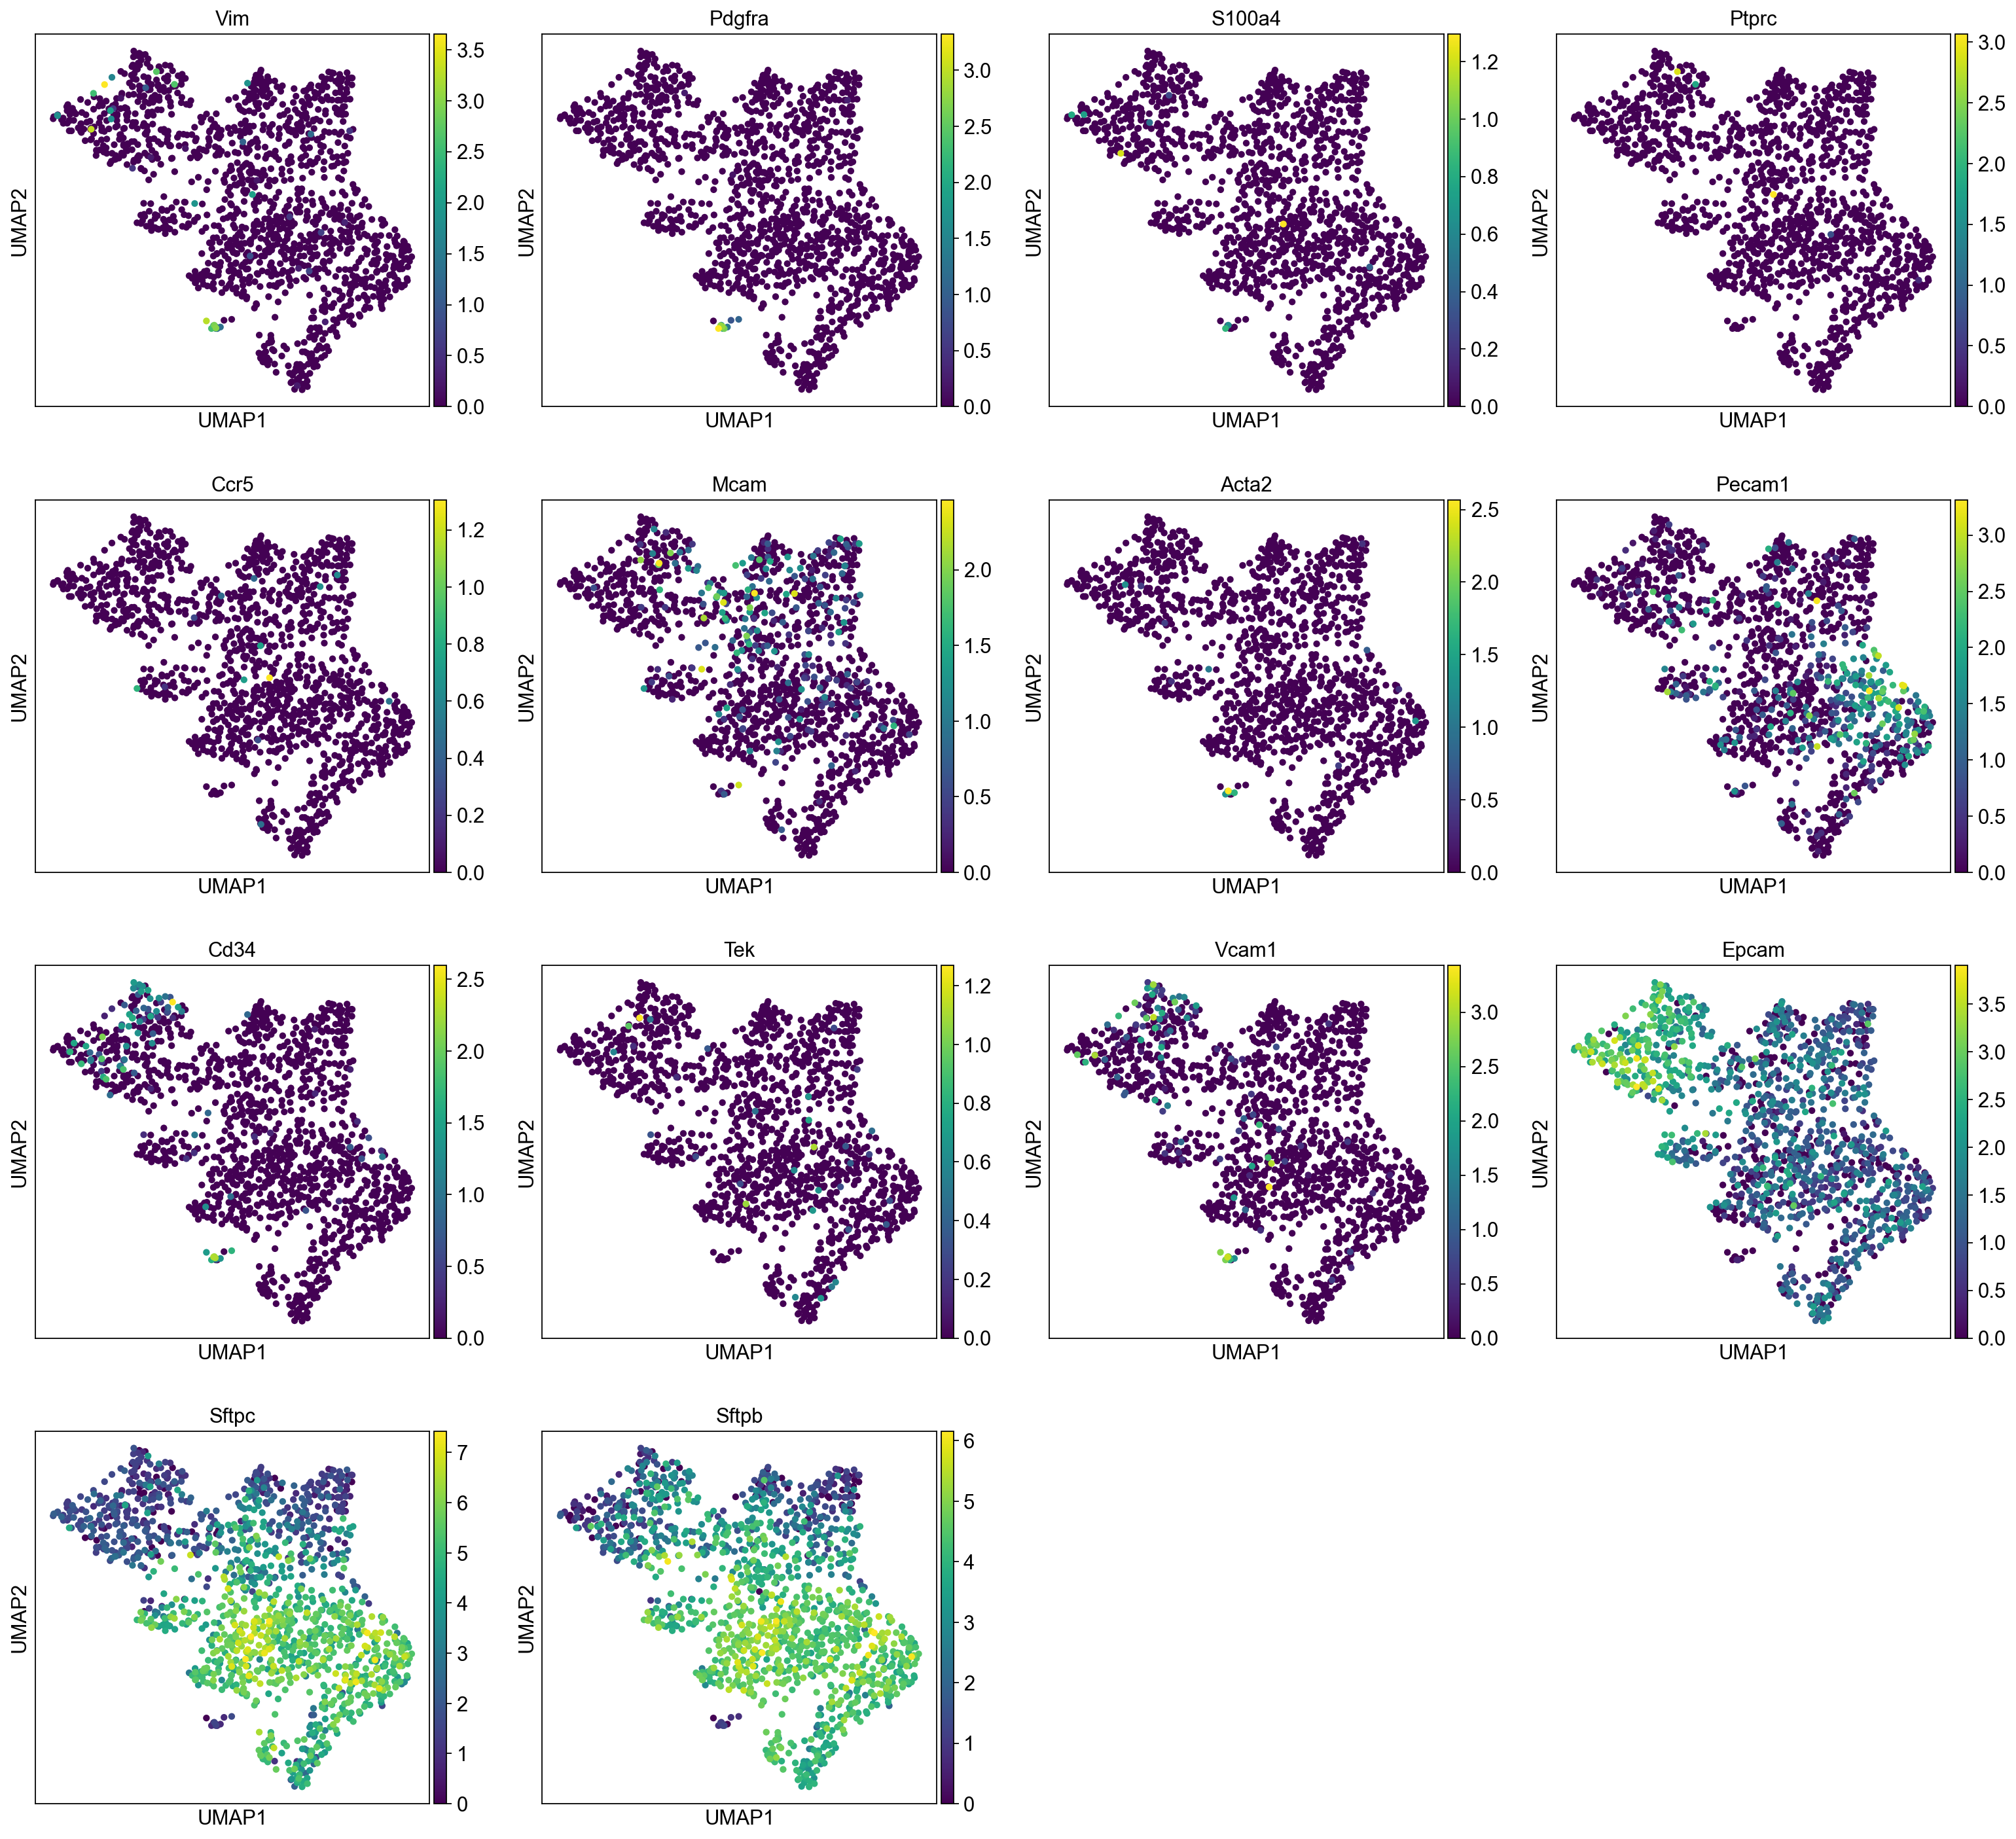

In [32]:
tme_markers  = ["Vim", "Pdgfra","S100a4", "Ptprc", "Ccr5", "Mcam", "Acta2", "Pecam1", "Cd34", "Tek","Vcam1","Epcam", "Sftpc", "Sftpb"]

from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color=tme_markers, save = 'sgKat7_tme')

In [33]:
tme = ['10']

In [34]:
adata.obs['cell_type'] = adata.obs['leiden_1.0'].map(lambda x:'tme' if x in tme else 'epi')

/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


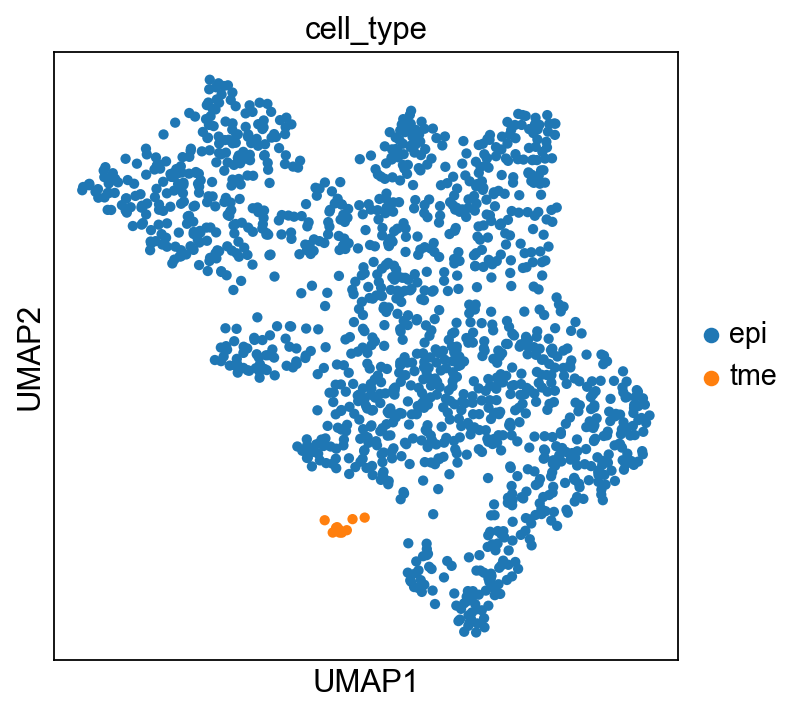

In [35]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color='cell_type', save = 'sgKat7_tme2')

In [36]:
genotype = adata.obs['Genotype']
cell_type = adata.obs['cell_type']
# new column
adata.obs['comp_groups'] = genotype.astype(str) + '_' + cell_type.astype(str)

In [37]:
adata

AnnData object with n_obs × n_vars = 1397 × 3576
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_well', 'bc2_well', 'bc3_well', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_scores', 'predicted_doublets', 'Genotype', 'leiden_0.5', 'leiden_1.0', 'leiden_1.5', 'cell_type', 'comp_groups'
    var: 'gene_id', 'genome', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'sample_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_0.5_colors', 'leiden_1.

# Subset Clusters

We are only interested in lung epithelial cancer cells, removing all TME clusters

In [38]:
adata_filt = adata[~adata.obs["leiden_1.0"].isin(tme),:]

/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


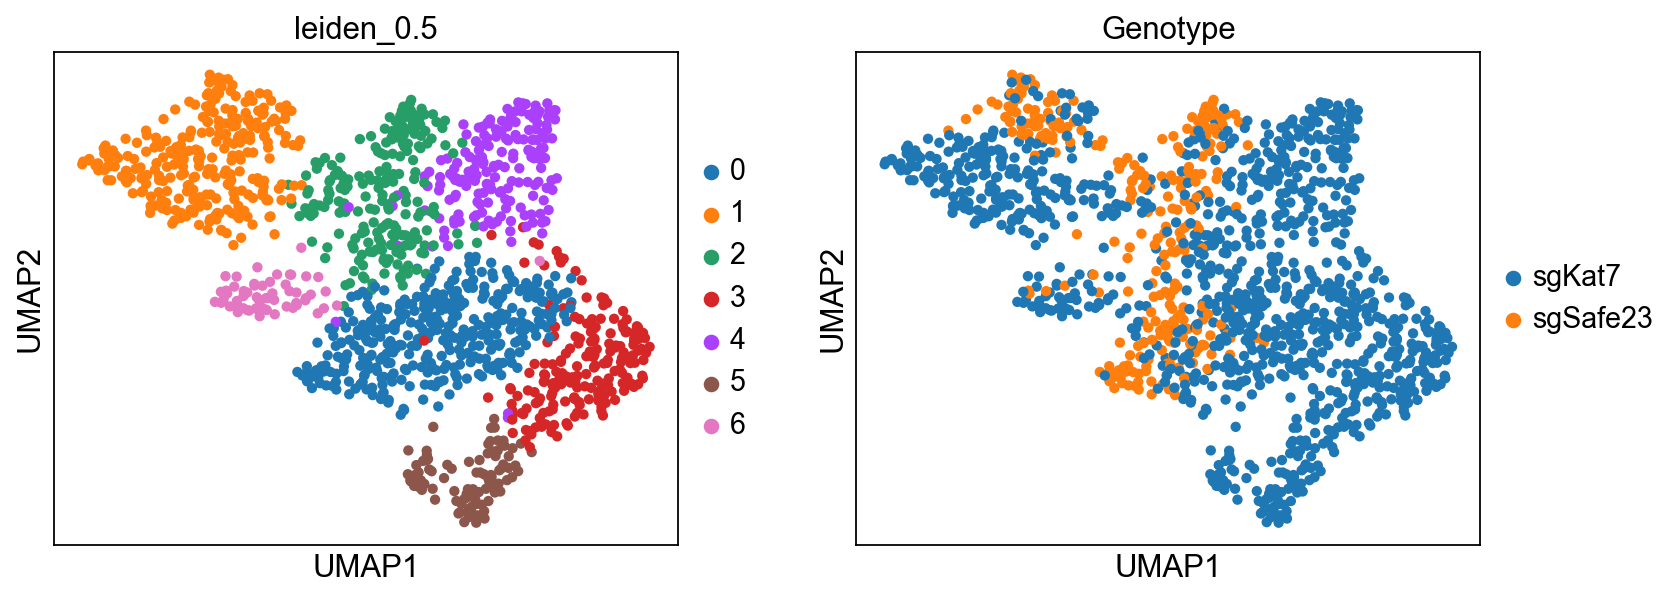

In [39]:
sc.pl.umap(adata_filt, color=["leiden_0.5", "Genotype"])

# Differential gene expression for enriched clusters

In [41]:
adata.raw.to_adata()

AnnData object with n_obs × n_vars = 1397 × 19550
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_well', 'bc2_well', 'bc3_well', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_scores', 'predicted_doublets', 'Genotype', 'leiden_0.5', 'leiden_1.0', 'leiden_1.5', 'cell_type', 'comp_groups'
    var: 'gene_id', 'genome', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'sample_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_0.5_colors', 'leiden_1.0_colors', 'leiden_1.5_colors', 'Genotype_colors', 'cell_type_colors'
    obs

In [55]:
# 1. Raw counts of cells per (cluster, genotype)
ct = pd.crosstab(adata_filt.obs['leiden_0.5'], adata_filt.obs['Genotype'])

# 2. Normalize by total number of cells per genotype (columns)
ct_norm = ct.div(ct.sum(axis=0), axis=1)  # divide each column by its sum

# 3. For each cluster, further normalize so the row sums to 1
ct_norm_frac = ct_norm.div(ct_norm.sum(axis=1), axis=0)  # divide each row by its sum

In [56]:
ct_norm_frac_sorted = ct_norm_frac.sort_values('sgKat7', ascending=False)
ct_norm_frac_sorted

Genotype      sgKat7  sgSafe23
leiden_0.5                    
3           1.000000  0.000000
4           1.000000  0.000000
5           1.000000  0.000000
6           0.648766  0.351234
1           0.461965  0.538035
0           0.417743  0.582257
2           0.187256  0.812744

In [57]:
adata_filt.obs['Groups'] = "unenriched"

In [58]:
enriched = ct_norm_frac_sorted.loc[ct_norm_frac_sorted['sgKat7'] > 0.9].index.tolist()
print(enriched)

['3', '4', '5']


In [59]:
adata_filt.obs.loc[adata_filt.obs['leiden_0.5'].isin(enriched), 'Groups'] = 'sgKat7_enriched'

/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


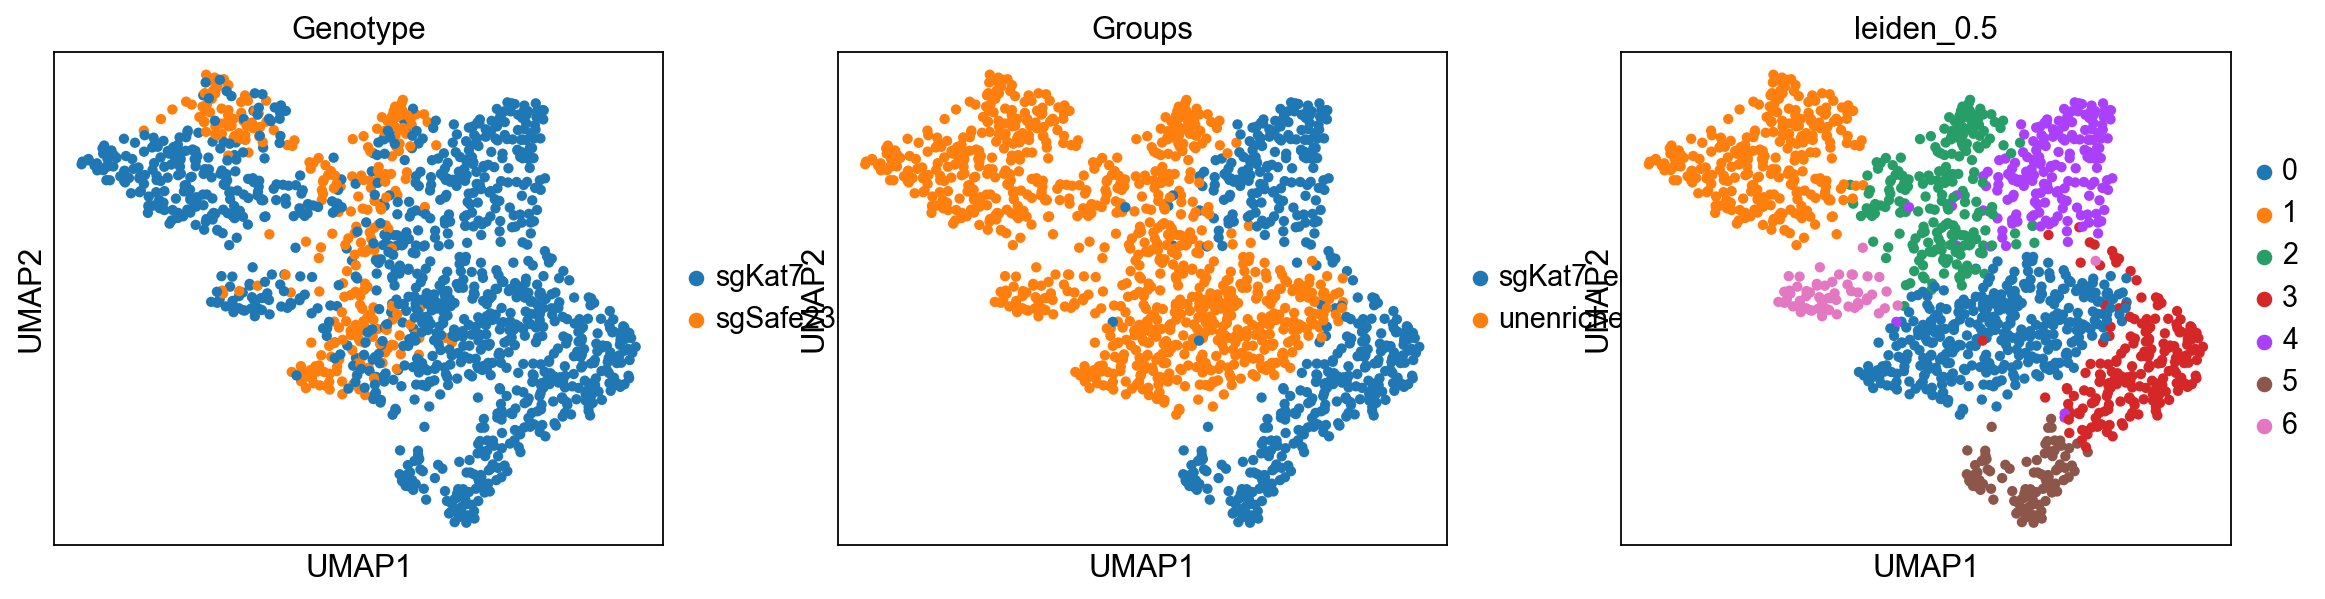

In [60]:
sc.pl.umap(adata_filt, color=['Genotype', 'Groups', 'leiden_0.5'])

In [61]:
sc.tl.rank_genes_groups(adata_filt, 'Groups', Group = 'sgKat7_enriched', reference = 'unenriched', method='wilcoxon', key_added = "cluster_wilcoxon")

In [62]:
dedf_cluster = sc.get.rank_genes_groups_df(adata_filt, group = 'sgKat7_enriched', key="cluster_wilcoxon")
select = dedf_cluster.loc[dedf_cluster['names'].isin(genes)]
select.sort_values('pvals_adj')

names    scores  logfoldchanges         pvals     pvals_adj
19474      Fat1 -9.698854       -0.819981  3.049012e-22  4.515772e-20
19419     Dusp5 -8.645144       -2.370933  5.373721e-18  4.797089e-16
19306      Chd1 -7.292126       -0.594167  3.051015e-13  1.543724e-11
19099     Dot1l -5.693415       -0.562556  1.245230e-08  3.303155e-07
18992     Trp53 -5.221424       -0.724270  1.775527e-07  3.869738e-06
424         Nf1  4.699381        0.349359  2.609509e-06  4.550929e-05
1238      Rnf43  2.726072        0.343878  6.409307e-03  4.430762e-02
1318      Stag2  2.575847        0.235416  9.999481e-03  6.434821e-02
1919        Rb1  1.865721        0.313893  6.208040e-02  2.784290e-01
16762    Cdkn2c -1.605413       -1.663238  1.084030e-01  4.215334e-01
2410       Tet2  1.485205        0.146102  1.374896e-01  4.987794e-01
2605       Tsc1  1.359649        0.215254  1.739410e-01  5.889410e-01
16338     Fbxw7 -1.325711       -0.149213  1.849353e-01  6.161095e-01
3458      Stk11  0.963661        0.102341  3.352158e-01  8.923569e-01
4076      Rbm10  0.747201        0.155598  4.549422e-01  1.000000e+00
7376      Setd2  0.191934        0.010703  8.477941e-01  1.000000e+00
8525      Rasa1  0.100673       -0.023528  9.198104e-01  1.000000e+00
13126     Ncoa6 -0.237564       -0.036141  8.122190e-01  1.000000e+00
13223     Cmtr2 -0.258526       -0.785222  7.960011e-01  1.000000e+00
13640      Pten -0.325688       -0.043816  7.446601e-01  1.000000e+00
11387  Arhgap35 -0.076075       -0.019788  9.393596e-01  1.000000e+00

In [63]:
dedf_cluster.to_csv('sgKat7_vs_sgSafe_DGE_cluster.csv')

# Export for MAST

In [ ]:
# Step 1: Filter counts_df to match adata_filt cells
cells_to_keep = adata_filt.obs_names
filtered_counts_df = counts_df.loc[cells_to_keep]

# Step 2: Add metadata columns from adata_filt
filtered_counts_df = filtered_counts_df.join(
    adata_filt.obs[['cell_type', 'comp_groups', 'Groups']]
)

# Step 3: Export counts matrix (genes as rows, cells as columns)
counts_only = filtered_counts_df.drop(['sample', 'Genotype', 'cell_type', 'comp_groups', 'Groups'], axis=1)
counts_only.T.to_csv('kat7_filtered_counts_matrix.csv')

# Step 4: Export metadata
metadata = filtered_counts_df[['sample', 'Genotype', 'cell_type', 'comp_groups', 'Groups']]
metadata.to_csv('kat7_filtered_metadata.csv')

In [67]:
genes_all = list(adata_filt.var_names)
group_names = ['sgKat7_enriched', 'sgKat7_unenriched']

def percent_express(adata, genes, group_col, group_names):
    perc = {}
    for grp in group_names:
        mask = (adata.obs[group_col] == grp)
        data = adata[mask].to_df()[genes]
        vals = (data > 0).sum(axis=0) / data.shape[0] * 100
        perc[grp] = vals
    return pd.DataFrame(perc)

percent_df_all = percent_express(adata_filt, genes_all, 'Groups', group_names)
percent_df_all.to_csv("percent_expression_sgKat7.csv")

# Cell Signatures

## Mouse signatures - PangDB

In [74]:
mouse_cell_sig = pd.read_csv("/Users/winslowlab-tang/Desktop/Figs_code/Fig6_code/cell_sigs/mouse/pdb_2.csv")

In [ ]:
at2_mouse = [x for x in mouse_cell_sig.Pulmonary_alveolar_type_II_cells.values.tolist() if pd.notnull(x)]
acinar_mouse = [x for x in mouse_cell_sig.Acinar_cells.values.tolist() if pd.notnull(x)]
tubu_mouse = [x for x in mouse_cell_sig.Proximal_tubule_cells.values.tolist() if pd.notnull(x)]

In [ ]:
sc.tl.score_genes(adata_filt, at2_mouse, score_name='at2_mouse', ctrl_size=len(at2_mouse))
sc.tl.score_genes(adata_filt, acinar_mouse, score_name='acinar_mouse', ctrl_size=len(acinar_mouse))
sc.tl.score_genes(adata_filt, tubu_mouse, score_name='tubu_mouse', ctrl_size=len(tubu_mouse))

# Plots

## Prepare data

In [111]:
adata_filt_raw = adata_filt.raw.to_adata() # create a object with all normalized genes. This will be used for plotting

In [112]:
adata_filt_raw.X.shape

(1386, 19550)

In [113]:
adata_filt.X.shape

(1386, 3576)

In [114]:
# scale data
adata_filt_raw.layers['scaled'] = sc.pp.scale(adata_filt_raw, copy=True).X

In [115]:
adata_filt_raw.layers['scaled'].shape

(1386, 19550)

## UMAPS

/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_tools/sca

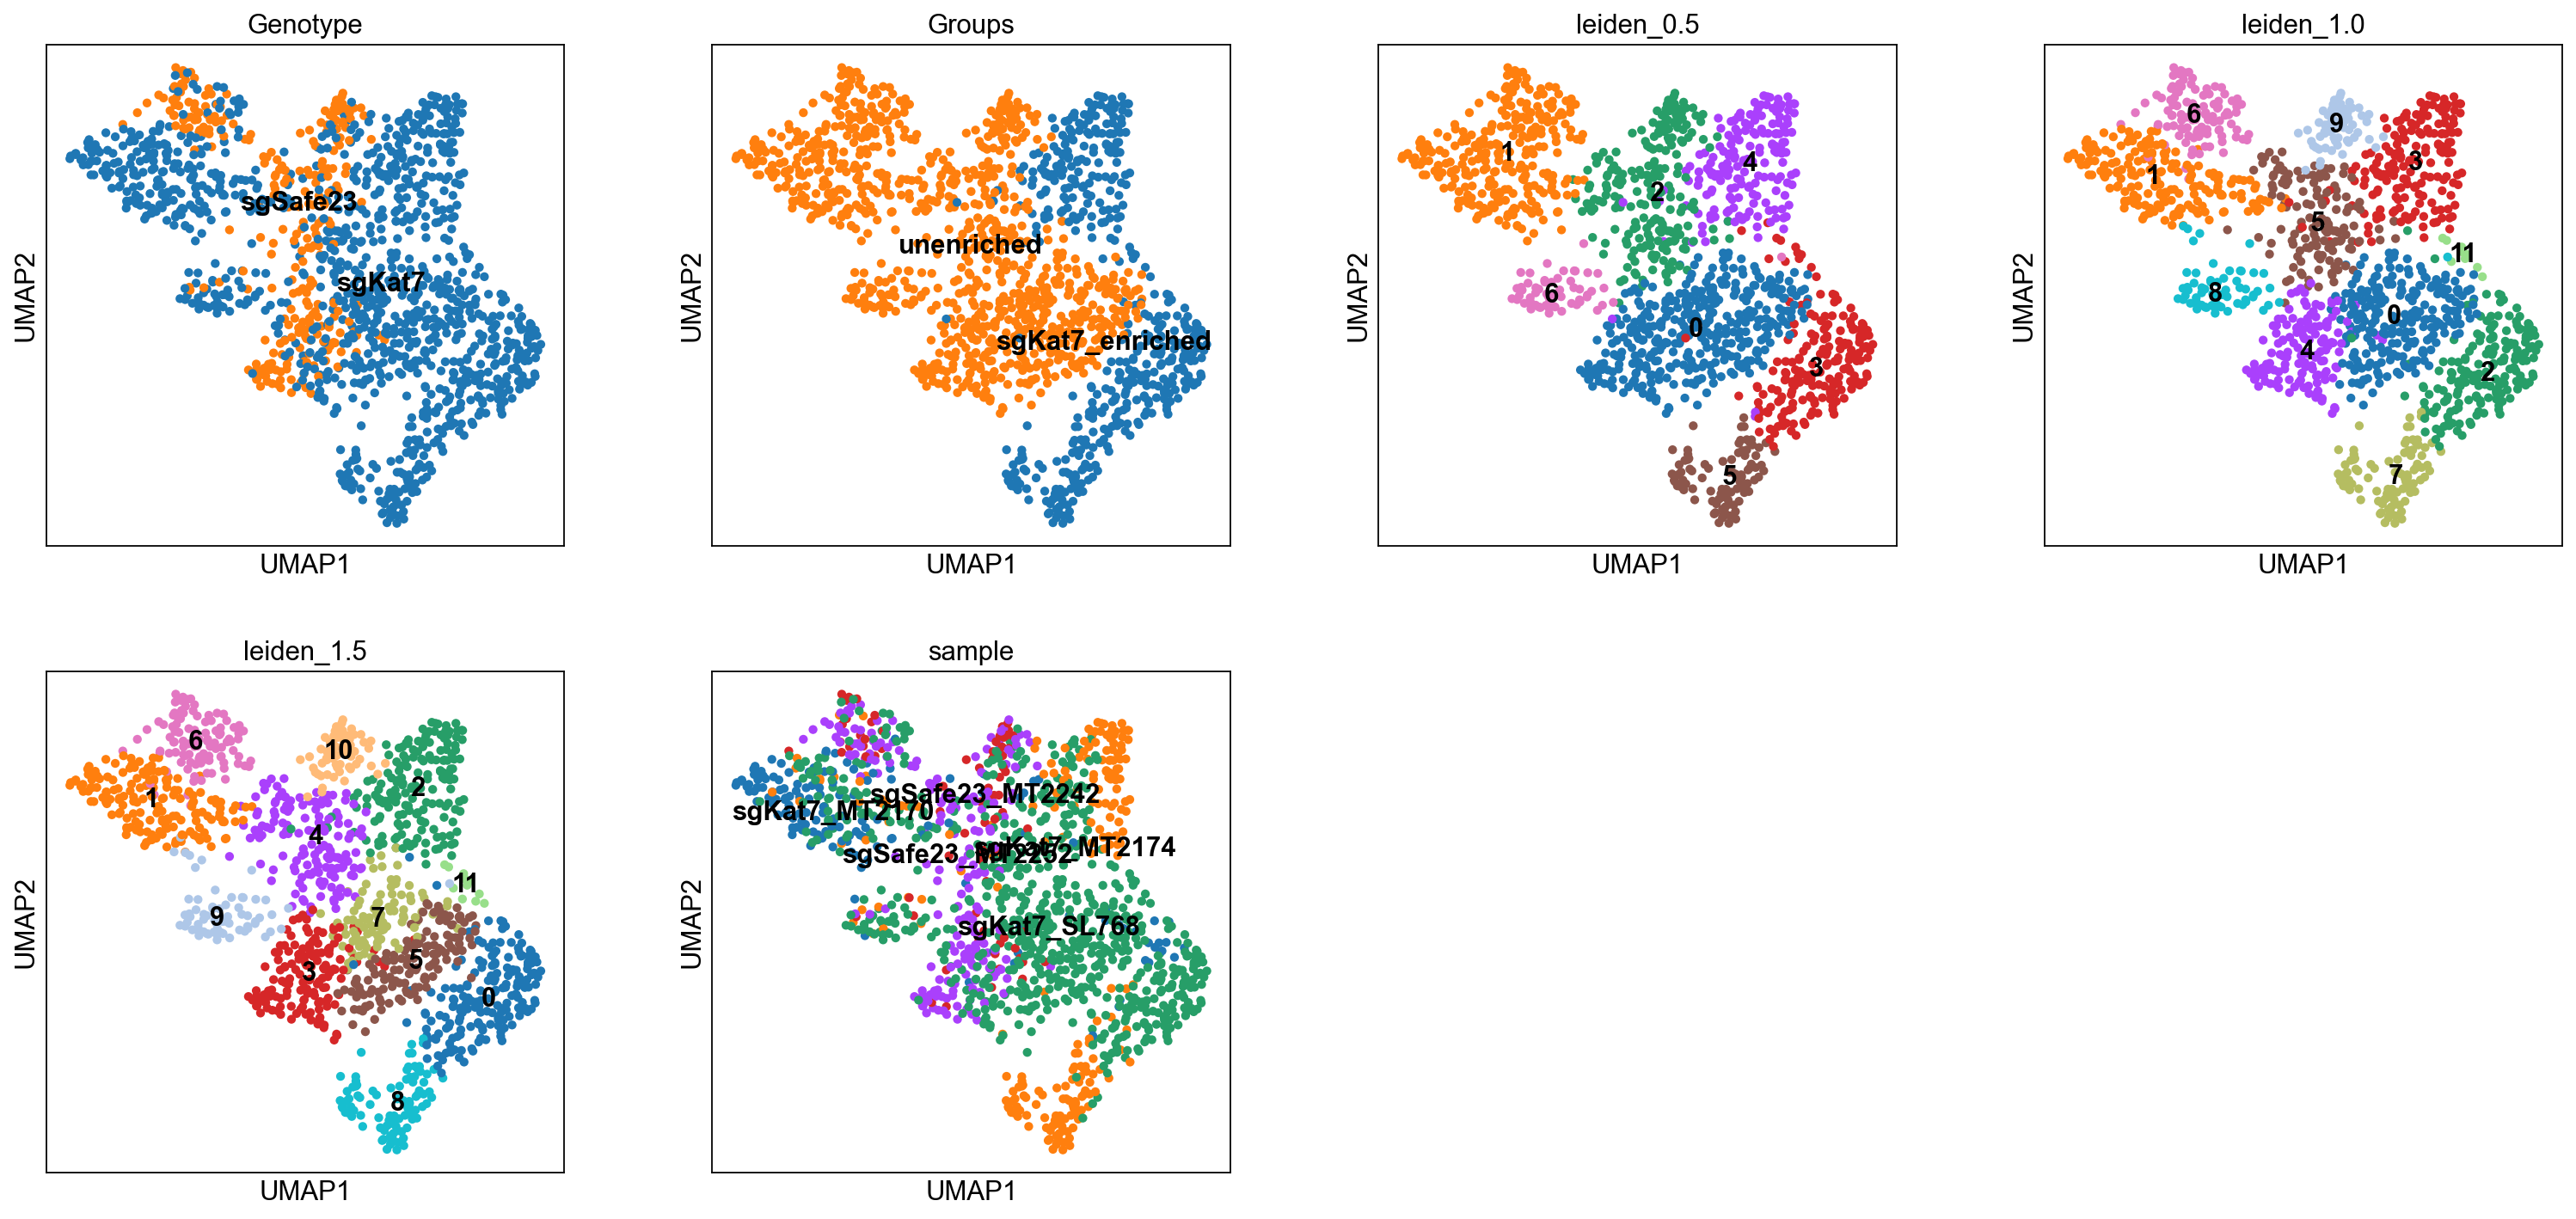

In [116]:
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata_filt, color=['Genotype', 'Groups', 'leiden_0.5', 'leiden_1.0', 'leiden_1.5', 'sample'],legend_loc="on data", save='_sgKat7_umaps')

/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


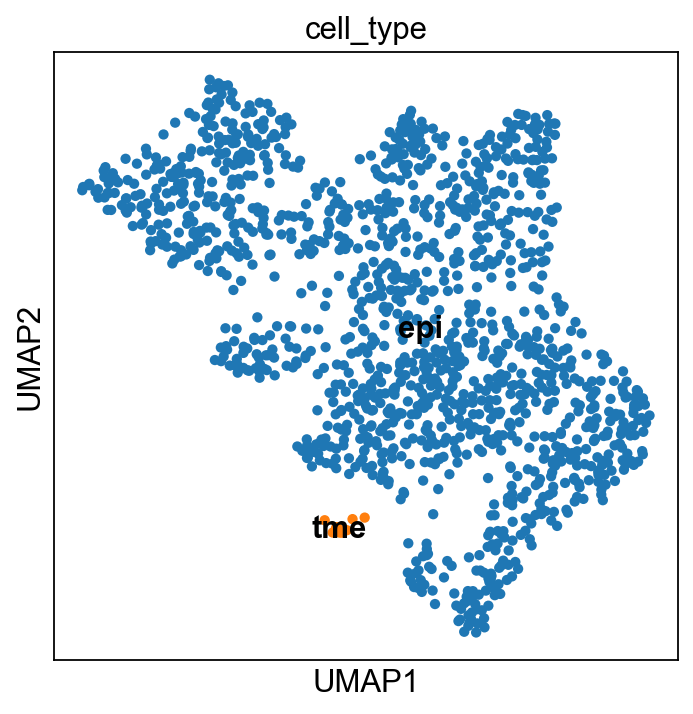

In [117]:
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color=['cell_type'],legend_loc="on data", save='_sgKat7_umaps')

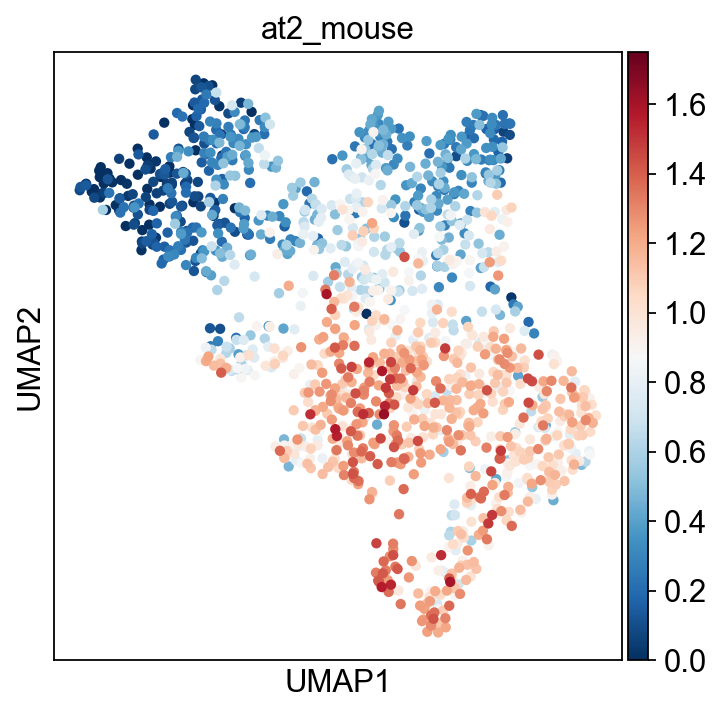

In [118]:
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(acts, color=['at2_mouse'], cmap='RdBu_r', vmin = 0, vmax = 1.75, save = '_sgKat7_at2_meta')

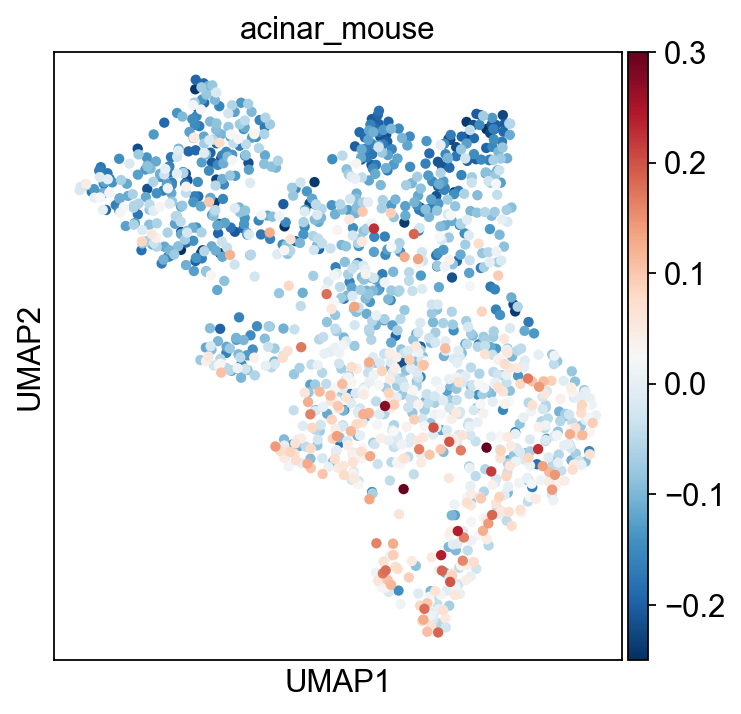

In [119]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(acts, color=['acinar_mouse'], cmap='RdBu_r', vmin = -0.25, vmax = 0.3, save = '_sgKat7_pancreas')

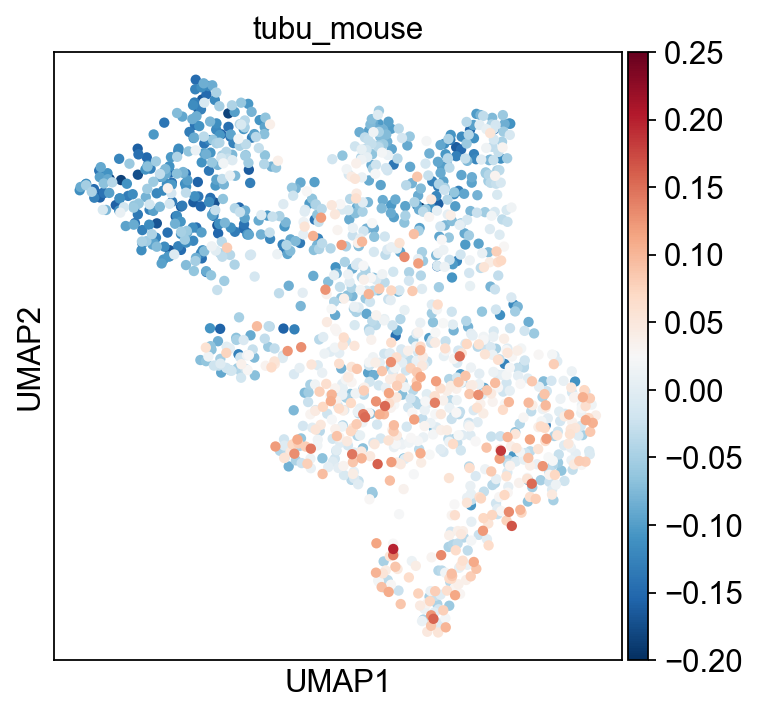

In [120]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(acts, color=['tubu_mouse'], vmin = -0.2, vmax = 0.25, cmap='RdBu_r', save = '_sgKat7_kidney')

## Barplots

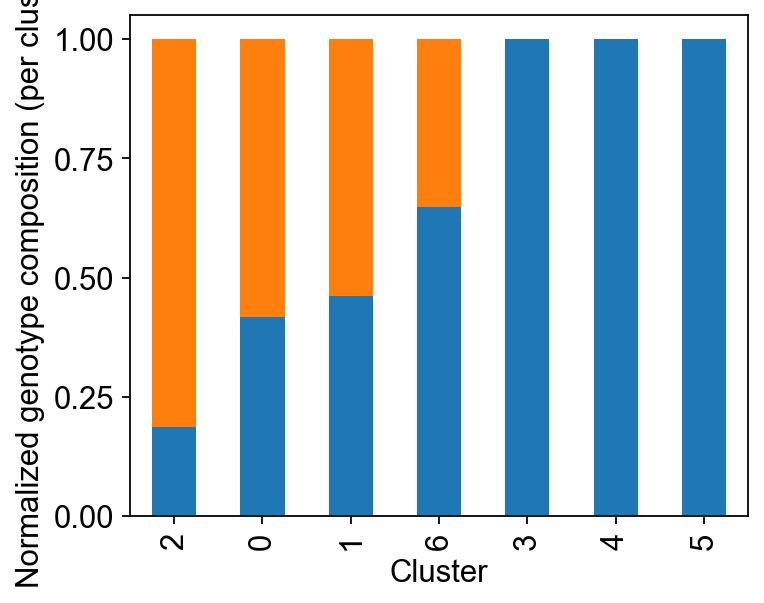

In [121]:
from matplotlib import pyplot as plt

desired_order = ['2', '0', '1', '6', '3', '4', '5']

ct_norm_frac_custom_order = ct_norm_frac_sorted.reindex(desired_order)

# Plot as stacked bar chart
ax = ct_norm_frac_custom_order.plot.bar(stacked=True, yticks=(0, 0.25, 0.5, 0.75, 1))
plt.ylabel('Normalized genotype composition (per cluster)')
plt.xlabel('Cluster')
plt.grid(False)             # <-- Remove background grid
plt.legend().remove()       # <-- Remove legend
plt.tight_layout()
plt.savefig('Kat7_genotype_cluster_bar_normalized.pdf')

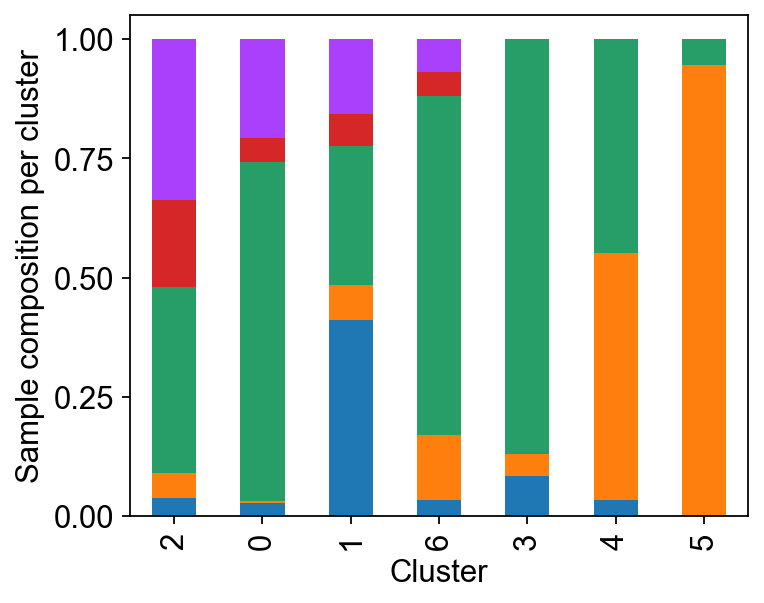

In [122]:
# Confirm your column name is correct
cl_order = ct_norm_frac_custom_order.sort_values('sgSafe23', ascending=False).index.tolist()

# Crosstab normalized by index: each row sums to 1
tmp_3 = pd.crosstab(adata_filt.obs['leiden_0.5'], adata_filt.obs['sample'], normalize='index')

# Reindex the crosstab by cluster order
tmp_3 = tmp_3.reindex(cl_order)

# Plot; you can specify colors here if you want, or default
ax = tmp_3.plot.bar(
    stacked=True,
    yticks=[0, 0.25, 0.5, 0.75, 1]
)

# Remove legend and grid lines as requested
ax.legend().remove()
ax.grid(False)

plt.ylabel("Sample composition per cluster")
plt.xlabel("Cluster")
plt.tight_layout()
plt.savefig('sgKat7_sample_bar.pdf')

In [157]:
tsgs = ['Cdkn2c', 'Chd1', 'Dot1l', 'Dusp5', 'Fat1', 'Fbxw7', 'Ncoa6','Nf1', 'Pten', 'Rasa1', 'Rb1', 'Setd2', 'Stk11', 'Trp53', 'Tsc1']

/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


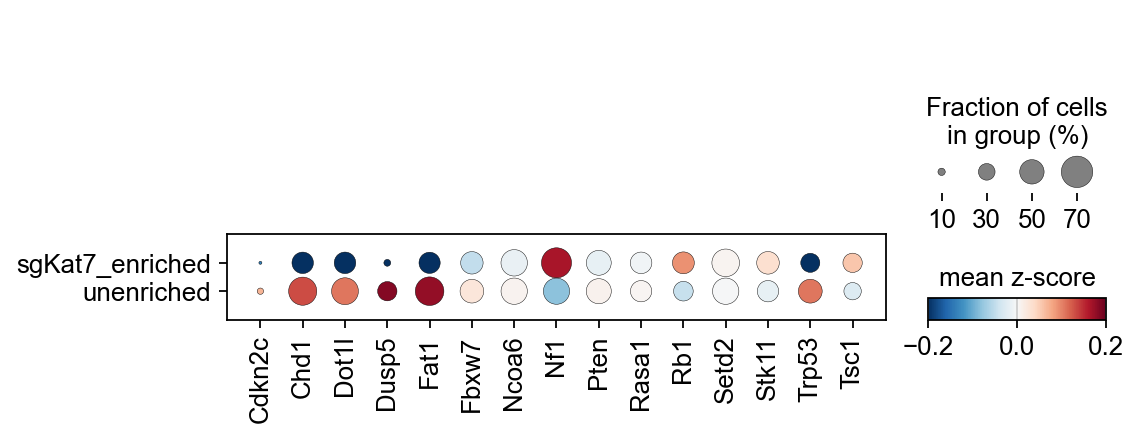

In [158]:
sc.pl.dotplot(adata_filt_raw, tsgs, 'Groups', layer='scaled',  colorbar_title='mean z-score',  vmin = -0.2, vmax = 0.2, cmap='RdBu_r',  save = 'tsg_sgKat7')

In [127]:
at2_genes = [ 'Abca3', 'Lamp3', 'Napsa', 'Sftpa1', 'Sftpb', 'Sftpc', 'Sftpd']

/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


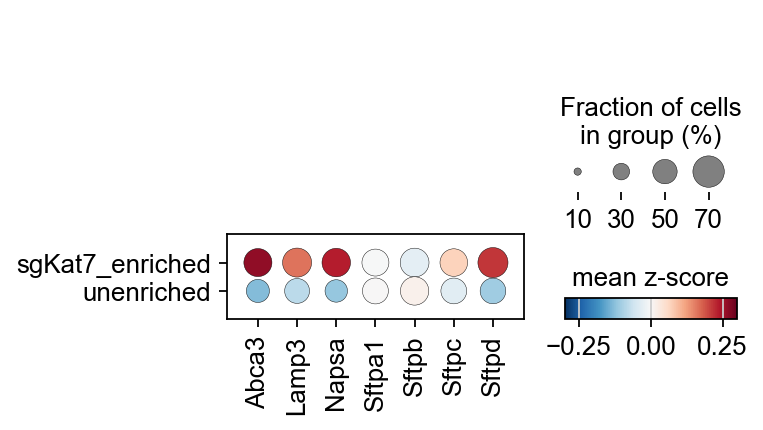

In [128]:
sc.pl.dotplot(adata_filt_raw, at2_genes, 'Groups', dendrogram = True, layer='scaled',  colorbar_title='mean z-score', vmin = -0.3, vmax = 0.3, cmap='RdBu_r', save = 'at2_sgKat7')

In [133]:
kidney = ['Slc16a7', 'Slc16a12', 'Slc23a1', 'Slc28a1']

/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


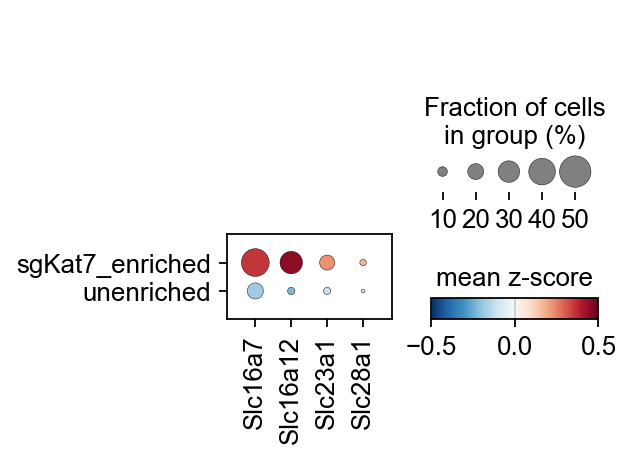

In [134]:
sc.pl.dotplot(adata_filt_raw, kidney, 'Groups', layer='scaled',  colorbar_title='mean z-score',  vmin = -0.5, vmax = 0.5, smallest_dot = 1, dot_max = 0.5, cmap='RdBu_r', save = 'kidney_sgkat7')

In [135]:
gastric = ['Anpep', 'Amy1', 'Pigr', "Slc5a1"]

/Users/winslowlab-tang/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


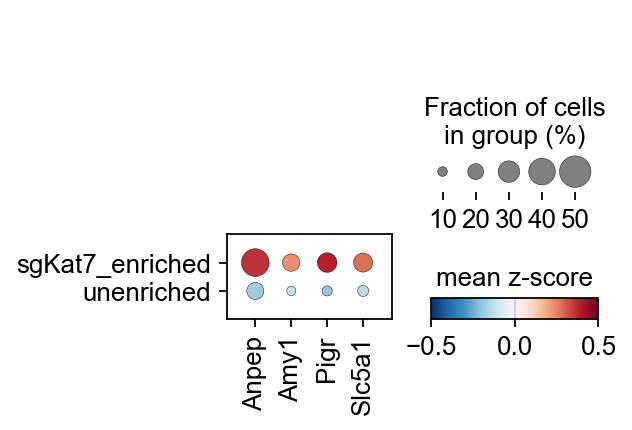

In [136]:
sc.pl.dotplot(adata_filt_raw, gastric, 'Groups', layer='scaled',  colorbar_title='mean z-score',  vmin = -0.5, vmax = 0.5, smallest_dot = 1, dot_max = 0.5, cmap='RdBu_r', save = 'gastric_sgkat7')

# Additional analyses

In [140]:
adata_filt.obs

sample species  gene_count  tscp_count  mread_count  \
03_02_54__s1  sgKat7_MT2170    mm10        7500       42975       108166   
03_03_62__s1  sgKat7_MT2170    mm10        5391       23677        57504   
03_08_17__s1  sgKat7_MT2170    mm10        4446       16684        40481   
03_15_76__s1  sgKat7_MT2170    mm10        4895       17616        43765   
03_16_36__s1  sgKat7_MT2170    mm10        6890       34646        89583   
...                     ...     ...         ...         ...          ...   
12_96_16__s2   sgKat7_SL768    mm10        2109        5392         8221   
12_96_24__s2   sgKat7_SL768    mm10        2624        7782        11948   
12_96_58__s2   sgKat7_SL768    mm10        3363       11834        18247   
12_96_67__s2   sgKat7_SL768    mm10        3135       10467        16005   
12_96_73__s2   sgKat7_SL768    mm10        2961        7132        11049   

             bc1_well bc2_well bc3_well  bc1_wind  bc2_wind  ...   at2_mca  \
03_02_54__s1       A3       A2       E6         3         2  ...  0.602781   
03_03_62__s1       A3       A3       F2         3         3  ...  0.458048   
03_08_17__s1       A3       A8       B5         3         8  ...  0.601618   
03_15_76__s1       A3       B3       G4         3        15  ...  0.339401   
03_16_36__s1       A3       B4      C12         3        16  ...  0.368033   
...               ...      ...      ...       ...       ...  ...       ...   
12_96_16__s2      A12      H12       B4        12        96  ...  0.786913   
12_96_24__s2      A12      H12      B12        12        96  ...  0.758764   
12_96_58__s2      A12      H12      E10        12        96  ...  0.501609   
12_96_67__s2      A12      H12       F7        12        96  ...  0.669737   
12_96_73__s2      A12      H12       G1        12        96  ...  0.392258   

              acinar_mca  hepa1_mca  hepa2_mca  hepa3_mca  hepa4_mca  \
03_02_54__s1   -0.142161   0.064181   0.595581   0.607166   0.255045   
03_03_62__s1    0.099491   0.016388   0.474492   0.516649   0.129908   
03_08_17__s1   -0.150614   0.006274   0.496704   0.398734   0.067329   
03_15_76__s1   -0.141311   0.062165   0.560298   0.481273   0.237278   
03_16_36__s1   -0.253749  -0.006779   0.432630   0.511335   0.128010   
...                  ...        ...        ...        ...        ...   
12_96_16__s2    0.156616   0.065917   0.241942   0.503755   0.035021   
12_96_24__s2   -0.018926   0.065693   0.253489   0.512379   0.033127   
12_96_58__s2   -0.127271   0.021554   0.388528   0.514550   0.033076   
12_96_67__s2   -0.011973   0.023024   0.251452   0.364751  -0.020928   
12_96_73__s2    0.085961  -0.033363   0.428858   0.326177   0.158042   

              hepa5_mca    hepa_g  tubu_mca      hpsc  
03_02_54__s1   0.167376 -0.011732  0.182987  0.611610  
03_03_62__s1   0.071135 -0.040618  0.170365  0.720487  
03_08_17__s1   0.031496 -0.032652  0.284061  0.371143  
03_15_76__s1   0.139713  0.005732  0.206864  0.754539  
03_16_36__s1   0.054142 -0.066053  0.229654  0.717463  
...                 ...       ...       ...       ...  
12_96_16__s2   0.020029  0.003408  0.179129  0.248732  
12_96_24__s2   0.044353 -0.018835  0.228677  0.342176  
12_96_58__s2   0.015937 -0.040620  0.234383  0.458593  
12_96_67__s2  -0.009930 -0.024160  0.230008  0.299344  
12_96_73__s2   0.092748 -0.019324  0.053387  0.771712  

[1386 rows x 67 columns]

In [ ]:
at2_mouse = adata_filt.obs[['at2_mouse', 'Groups', 'Genotype']]
acinar_mouse = adata_filt.obs[['acinar_mouse', 'Groups', 'Genotype']]
kidney_mouse = adata_filt.obs[['tubu_mouse', 'Groups', 'Genotype']]

In [142]:
import os
output_directory = "/Users/winslowlab-tang/Desktop/Figs_code/Fig6_code/cell_sigs/mouse/mouse_gene_signature_scores/Kat7"
at2_mouse.to_csv(os.path.join(output_directory, 'at2_mouse.csv'), index=True)
acinar_mouse.to_csv(os.path.join(output_directory, 'acinar_mouse.csv'), index=True)
kidney_mouse.to_csv(os.path.join(output_directory, 'kidney_mouse.csv'), index=True)

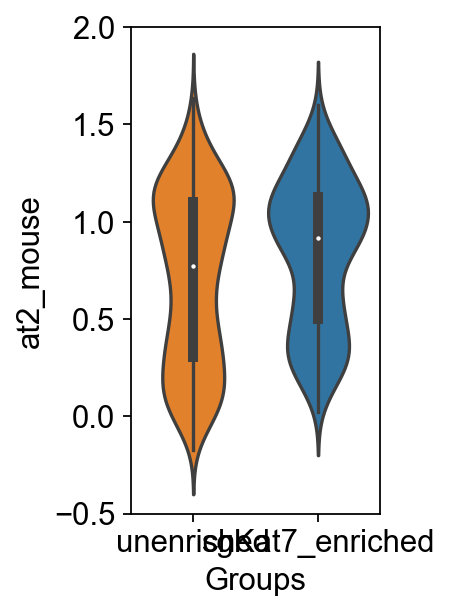

In [143]:
# Create the violin plot
plt.figure(figsize=(2, 4))
sns.violinplot(x='Groups', y='at2_mouse', data=at2_mouse, order=["unenriched", "sgKat7_enriched"], palette=["#ff7f0e", "#1f77b4"])

# Add title and labels
#plt.title('Violin Plot of at2_mouse Scores by Groups')
#plt.xlabel('Genotype')
#plt.ylabel('AT2 Cell Signature Score')

plt.ylim(-0.5, 2.0)  # Set y-axis range from -0.5 to 2.5
#plt.yticks([-0.5, 0, 1, 1.5, 2])  # Set y-axis ticks

# Remove grid
plt.grid(False)

# Save as PDF
plt.savefig('/Volumes/G_DRIVE_SSD/Parse_WT/Analyzed_plots/sgKat7/at2_mouse_violinplot.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [144]:
group1 = at2_mouse[at2_mouse['Groups'] == 'unenriched']['at2_mouse']
group2 = at2_mouse[at2_mouse['Groups'] == 'sgKat7_enriched']['at2_mouse']

print(group1.mean(), group2.mean())

0.7121860045843333 0.8361196627012036


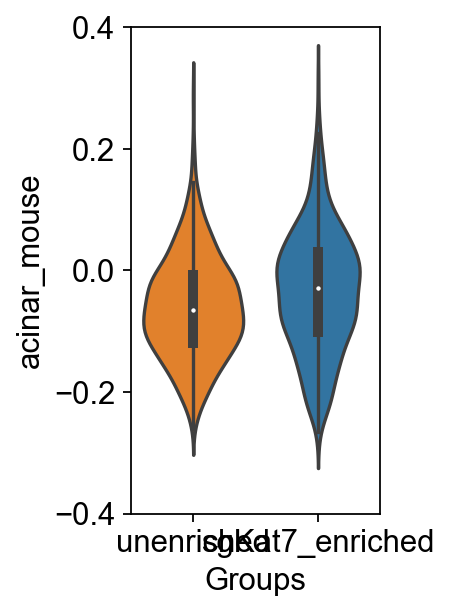

In [145]:
# Create the violin plot
plt.figure(figsize=(2, 4))
sns.violinplot(x='Groups', y='acinar_mouse', data=acinar_mouse, order=["unenriched", "sgKat7_enriched"], palette=["#ff7f0e", "#1f77b4"])

# Add title and labels
#plt.title('Violin Plot of at2_mouse Scores by Groups')
#plt.xlabel('Genotype')
#plt.ylabel('AT2 Cell Signature Score')

plt.ylim(-0.4, 0.4)  # Set y-axis range from -0.5 to 2.5
#plt.yticks([-0.5, 0, 1, 1.5, 2])  # Set y-axis ticks

# Remove grid
plt.grid(False)

# Save as PDF
plt.savefig('/Volumes/G_DRIVE_SSD/Parse_WT/Analyzed_plots/sgKat7/acinar_mouse_violinplot.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

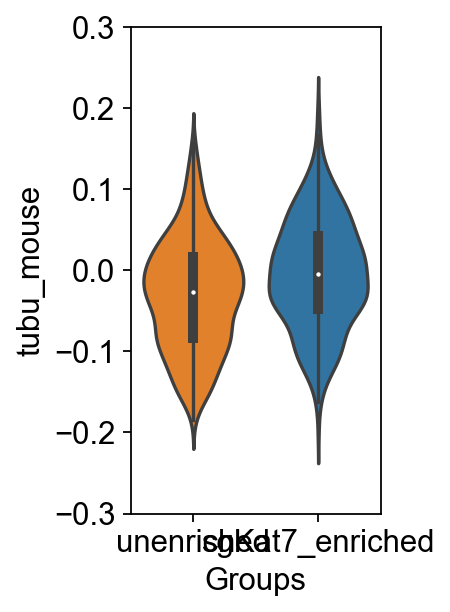

In [146]:
# Create the box plot
plt.figure(figsize=(2, 4))
sns.violinplot(x='Groups', y='tubu_mouse', data=kidney_mouse, order = ["unenriched", "sgKat7_enriched"], palette=["#ff7f0e", "#1f77b4"])

# Overlay the individual data points
#sns.stripplot(x='Genotype', y='at2_full', data=data, color='black', alpha=0.5, jitter=True)

plt.ylim(-0.3, 0.3)  # Set y-axis range from -0.5 to 2.5
#plt.yticks([-0.5, 0, 1, 1.5, 2])  # Set y-axis ticks

# Remove grid
plt.grid(False)

# Save as PDF
plt.savefig('/Volumes/G_DRIVE_SSD/Parse_WT/Analyzed_plots/sgKat7/ptc_mouse_violinplot.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

## Statistical Testing

In [147]:
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

# Separate the data into two groups
group1 = kidney_mouse[kidney_mouse['Groups'] == 'unenriched']['tubu_mouse']
group2 = kidney_mouse[kidney_mouse['Groups'] == 'sgKat7_enriched']['tubu_mouse']

# Perform the Wilcoxon rank-sum test
stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
# stat, p_value = ttest_ind(group1, group2, alternative='two-sided')

# Print the results
print(f"Wilcoxon rank-sum test statistic: {stat}")
print(f"P-value: {p_value}")

Wilcoxon rank-sum test statistic: 168871.0
P-value: 3.9400899417381034e-10


In [148]:
# Separate the data into two groups
group1 = acinar_mouse[acinar_mouse['Groups'] == 'unenriched']['acinar_mouse']
group2 = acinar_mouse[acinar_mouse['Groups'] == 'sgKat7_enriched']['acinar_mouse']

# Perform the Wilcoxon rank-sum test
stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

# Print the results
print(f"Wilcoxon rank-sum test statistic: {stat}")
print(f"P-value: {p_value}")

Wilcoxon rank-sum test statistic: 176925.0
P-value: 3.257285162128803e-07


In [149]:
# Separate the data into two groups
group1 = at2_mouse[at2_mouse['Groups'] == 'unenriched']['at2_mouse']
group2 = at2_mouse[at2_mouse['Groups'] == 'sgKat7_enriched']['at2_mouse']

# Perform the Wilcoxon rank-sum test
stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

# Print the results
print(f"Wilcoxon rank-sum test statistic: {stat}")
print(f"P-value: {p_value}")

Wilcoxon rank-sum test statistic: 179829.0
P-value: 2.68150013979787e-06
